In [61]:
import pandas as pd
import numpy as np
from scipy.optimize import least_squares

In [22]:
thp = pd.read_csv('thp_log.csv', parse_dates=['datetime'])
thp_pa = thp.loc[thp['pressure'] > 10000, 'pressure']
thp.loc[thp['pressure'] > 10000, 'pressure'] = thp_pa / 100
thp = thp.set_index('datetime').sort_values('datetime')

ut330c = pd.read_csv('UNT330C_20220807_202941.log.csv', parse_dates=['datetime'], header=0, names=['sample_number', 'datetime', 'tempDegC', 'relHumidityPercent', 'pressure_hPa', 'dewPoint', 'tempDegF'], skiprows=1)

In [23]:
ut330c = ut330c[~ut330c['datetime'].isna()]
ut330c_offset = pd.Timestamp('2022-08-07 18:36:23') - ut330c.iloc[-1]['datetime']
ut330c['datetime'] = ut330c['datetime'] + ut330c_offset

In [26]:
thp_merged = pd.merge_asof(ut330c.set_index('datetime'), thp, left_index=True, right_index=True)

,sample_number,datetime,tempDegC,relHumidityPercent,pressure_hPa,dewPoint,tempDegF
19282,19284.0,2022-08-07 18:35:43,28.4,46.0,1023.7,15.7,83.1
19283,19285.0,2022-08-07 18:35:53,28.4,46.0,1023.7,15.7,83.1
19284,19286.0,2022-08-07 18:36:03,28.4,46.0,1023.6,15.7,83.1
19285,19287.0,2022-08-07 18:36:13,28.4,46.0,1023.7,15.7,83.1
19286,19288.0,2022-08-07 18:36:23,28.4,51.5,1023.7,17.4,83.1


In [29]:
thp_merged.head()

,sample_number,tempDegC,relHumidityPercent,pressure_hPa,dewPoint,tempDegF,temperature,pressure,humidity
datetime,,,,,,,,,
2022-08-05 12:57:18,2.0,31.2,43.3,1024.9,17.2,88.2,37.044141,1019.898848,26.942433
2022-08-05 12:57:28,3.0,31.2,39.1,1020.7,15.6,88.2,37.049219,1019.910537,26.878201
2022-08-05 12:57:38,4.0,31.1,38.1,1020.6,15.1,88.0,37.052344,1019.888794,26.790239
2022-08-05 12:57:48,5.0,31.1,37.7,1020.7,15.0,88.0,37.057812,1019.935941,26.737571
2022-08-05 12:57:58,6.0,31.1,37.4,1020.5,14.9,88.0,37.073437,1019.907091,26.760655


<AxesSubplot:xlabel='datetime'>

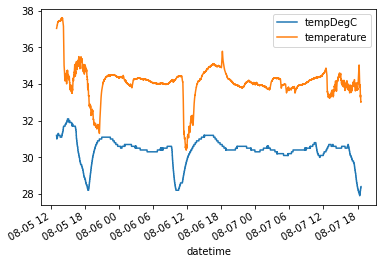

In [33]:
thp_merged[['tempDegC', 'temperature']].plot()

<AxesSubplot:xlabel='datetime'>

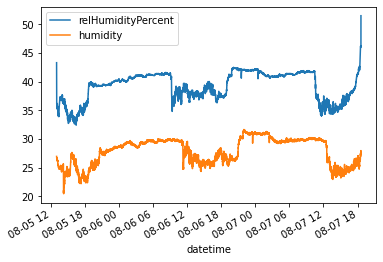

In [41]:
thp_merged[['relHumidityPercent', 'humidity']].plot()

<AxesSubplot:xlabel='datetime'>

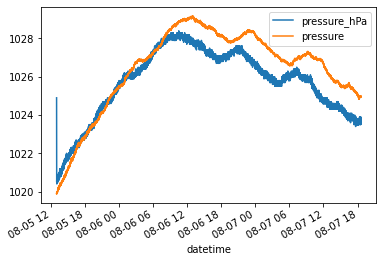

In [40]:
thp_merged[['pressure_hPa', 'pressure']].plot()

In [130]:
temp_offset = thp_merged['tempDegC'].mean() - thp_merged['temperature'].mean()
thp_merged['temperature_offsetted'] = thp_merged['temperature'].shift(-600) + temp_offset

humidity_offset = thp_merged['relHumidityPercent'].mean() - thp_merged['humidity'].mean()
thp_merged['humidity_offsetted'] = thp_merged['humidity'].shift(-600) + humidity_offset

pressure_offset = thp_merged['pressure_hPa'].mean() - thp_merged['pressure'].mean()
thp_merged['pressure_offsetted'] = thp_merged['pressure'].shift(-600) + pressure_offset - .1


In [141]:
def correct(x, dep):
    return (x[0] * dep.shift(int(x[2])) + x[1])
    
def residuals(x, dep, indep):
    return (correct(x, dep) - indep).iloc[3000:-3000]

offset_guess = thp_merged['tempDegC'].mean() - thp_merged['temperature'].mean()
res = least_squares(residuals, (1, offset_guess, -600), bounds=([.9, -10, -2000], [1.1, 10, 2000]), args=(thp_merged['temperature'], thp_merged['tempDegC']), diff_step=10, method='trf')
thp_merged['temperature_corrected'] = correct(res.x, thp_merged['temperature'])

offset_guess = thp_merged['relHumidityPercent'].mean() - thp_merged['humidity'].mean()
res = least_squares(residuals, (1, offset_guess, -600), bounds=([.9, -20, -2000], [1.1, 20, 2000]), args=(thp_merged['humidity'], thp_merged['relHumidityPercent']), diff_step=10, method='trf')
thp_merged['humidity_corrected'] = correct(res.x, thp_merged['humidity'])

offset_guess = thp_merged['pressure_hPa'].mean() - thp_merged['pressure'].mean()
res = least_squares(residuals, (1, offset_guess, -600), bounds=([.9, -2, -2000], [1.1, 2, 2000]), args=(thp_merged['pressure'], thp_merged['pressure_hPa']), diff_step=10, method='trf')
thp_merged['pressure_corrected'] = correct(res.x, thp_merged['pressure'])
res.x

array([ 9.99828305e-01, -7.34891032e-01, -7.91947485e+02])

<AxesSubplot:xlabel='datetime'>

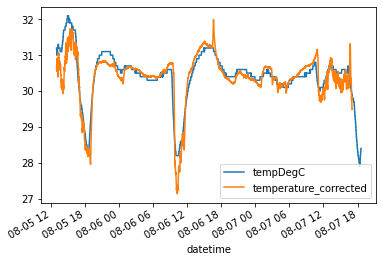

In [110]:
thp_merged[['tempDegC', 'temperature_corrected']].plot()

<AxesSubplot:xlabel='datetime'>

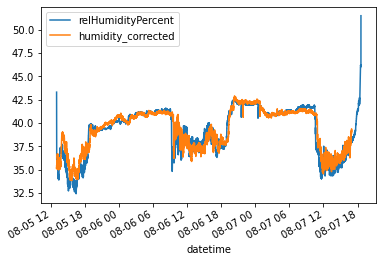

In [134]:
thp_merged[['relHumidityPercent', 'humidity_corrected']].plot()

<AxesSubplot:xlabel='datetime'>

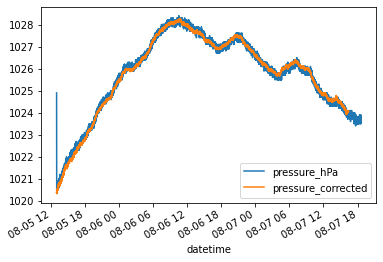

In [137]:
thp_merged[['pressure_hPa', 'pressure_corrected']].plot()